Preprocessing step

In [1]:
import os, pandas as pd, urllib
from dsi.dsi import DSI

In [2]:
def downloadImages(path_to_csv, imageFolder):
    """
    Read and download the images from the SDSC server
    """
    if not os.path.exists(imageFolder):
        os.makedirs(imageFolder)

    df = pd.read_csv(path_to_csv)
    counter = 0
    for url in df["FILE"]:
        if counter == 10:
            return
        filename = url.rsplit('/', 1)[1]
        
        dst = imageFolder + filename
        if not os.path.exists(dst):
            urllib.request.urlretrieve(url, dst)
        counter += 1

In [3]:
def count_burned_pixels(df):
    return df

In [4]:
image_path = "images/"
input_csv = "wildfiredata.csv"
db_name = 'wildfire.db'
output_csv = "wildfire_output.csv"
datacard = "wildfire_oceans11.yml"
table_name = "wfdata"
columns_to_keep = ["wind_speed", "wdir", "smois", "burned_area"]

In [7]:
# Something like that could be needed for macos with zscaler
os.environ["REQUESTS_CA_BUNDLE"] = "/Users/pascalgrosset/Zscaler-Root-CA.pem"
os.environ["SSL_CERT_FILE"] = "/Users/pascalgrosset/Zscaler-Root-CA.pem"

In [8]:
if not os.path.exists(image_path):
    os.makedirs(image_path)
downloadImages(input_csv, image_path)

if os.path.exists(db_name):
    os.remove(db_name)

In [11]:
dsi = DSI(db_name)

dsi.read(input_csv, "Ensemble", table_name=table_name)
dsi.read(datacard, "Oceans11Datacard") # change to GenesisDatacard

Created an instance of DSI with the Sqlite backend: wildfire.db
Loaded wildfiredata.csv into tables: wfdata, simulation
Loaded wildfire_oceans11.yml into the table oceans11_datacard


In [12]:
wildfire_data = dsi.get_table(table_name, True, True).head(10)


Storing all data for the table: wfdata as a collection
Note: Includes 'dsi_table_name' column for dsi.update(); DO NOT modify. Drop if not updating data.


In [13]:
updatedFilePaths = []
for url_image in wildfire_data['FILE']:
    image_name = url_image.rsplit('/', 1)[1]
    filePath = image_path + image_name
    updatedFilePaths.append(filePath)
wildfire_data['LOCAL_PATH'] = updatedFilePaths

In [29]:
wildfire_data = count_burned_pixels(wildfire_data)

In [30]:
dsi.update(wildfire_data)

Updating the active backend with the input collection of data


In [31]:
dsi.display(table_name, display_cols=columns_to_keep)


Table: wfdata

wind_speed | wdir  | smois | burned_area
----------------------------------------
2.0        | 180.0 | 0.05  | 122388.0   
8.0        | 225.0 | 0.05  | 169302.0   
8.0        | 195.0 | 0.05  | 187542.0   
5.0        | 240.0 | 0.05  | 181583.0   
8.0        | 225.0 | 0.05  | 168955.0   
8.0        | 225.0 | 0.05  | 83722.0    
8.0        | 225.0 | 0.05  | 183566.0   
3.0        | 180.0 | 0.05  | 104288.0   
12.0       | 255.0 | 0.05  | 140347.0   
12.0       | 240.0 | 0.05  | 183895.0   



In [18]:
!pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.3 MB/s  0:00:04 eta 0:00:010m
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 7.3 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]



Training/testing the data

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score)

In [32]:
TEST_SIZE = .20
SEED = 15
df = wildfire_data

features = ['wind_speed','wdir','smois','fuels','ignition']
target = "burned_area"
pred_type = "Regression"
all_models = ["Decision Tree", "Random Forest", "KNN", "Linear Regression", 
                   "Ridge Regression", "Lasso Regression", "ElasticNet"]
selected_models = ["Decision Tree", "KNN"]

all_metrics = ["MSE", "RMSE", "MAE", "R²"]
metrics = ["MSE"]

In [33]:
X = df[features].select_dtypes(include=[np.number]).fillna(0)
y = df[target]

# if pred_type == "Classification":
y = y.astype("category").cat.codes
X = X.apply(lambda col: col.astype("category").cat.codes)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [34]:
start_time = time.time()
results = []
for model_name in selected_models:
    grid = None
    if model_name == "Decision Tree":
        param_grid = {'max_depth': [1, 2, 3, 4, 5, 6 ,7, 8, 9, 10, 12, 15, 17, 20, 25, 30, 35, 40, 45, 50],
                    'min_samples_split': [2, 3, 4, 5]}
        if pred_type == "Classification":
            grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy', error_score='raise')
        else:
            grid = GridSearchCV(DecisionTreeRegressor(random_state=SEED), param_grid, cv=5, scoring='neg_mean_squared_error')
    elif model_name == "Random Forest":
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 3, 4, 5]}
        if pred_type == "Classification":
            grid = GridSearchCV(RandomForestClassifier(random_state=SEED), param_grid, scoring='accuracy')
        else:
            grid = GridSearchCV(RandomForestRegressor(random_state=SEED), param_grid, scoring='neg_mean_squared_error')
    elif model_name == "KNN":
        param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                    'weights': ['uniform', 'distance']}
        if pred_type == "Classification":
            grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy')
        else:
            grid = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error')
    elif model_name == "Linear Regression" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}
        grid = GridSearchCV(LinearRegression(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??

    elif model_name == "Ridge Regression" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False]}
        grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??
    
    elif model_name == "Lasso Regression" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10],  'fit_intercept': [True, False], 'max_iter': [1000, 5000, 10000]}
        grid = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??
    
    elif model_name == "ElasticNet" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'fit_intercept': [True, False]}
        grid = GridSearchCV(ElasticNet(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??
    
    if grid is None:
        raise RuntimeError(f"Wrong selection of model: {model_name} with {pred_type} prediction")
    
    grid.fit(x_train, y_train)
    y_pred = grid.predict(x_test)

    row = {"Model": model_name}
    if pred_type == "Classification":
        if "Accuracy" in metrics:  row["Accuracy"] = accuracy_score(y_test, y_pred)
        if "Precision" in metrics:  row["Precision"] = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        if "Recall" in metrics:  row["Recall"] = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        if "F1" in metrics:  row["F1"] = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    else:
        if "MSE" in metrics:  row["MSE"] = mean_squared_error(y_test, y_pred)
        if "RMSE" in metrics:  row["RMSE"] = root_mean_squared_error(y_test, y_pred)
        if "MAE" in metrics:  row["MAE"] = mean_absolute_error(y_test, y_pred)
        if "R²" in metrics:  row["R²"] = r2_score(y_test, y_pred)
    
    row["Optimal Hyperparameters"] = grid.best_params_
    results.append(row)

print(f"Finished in {time.time() - start_time:.1f}s")
output_df = pd.DataFrame(results)

/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = meth

Finished in 3.7s


/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pascalgrosset/projects/dsi/venv_dsi_dev/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = meth

In [35]:
output_df

,Model,MSE,Optimal Hyperparameters
0,Decision Tree,26.000000,"{'max_depth': 4, 'min_samples_split': 3}"
1,KNN,22.318422,"{'n_neighbors': 4, 'weights': 'distance'}"


In [36]:
%matplotlib inline

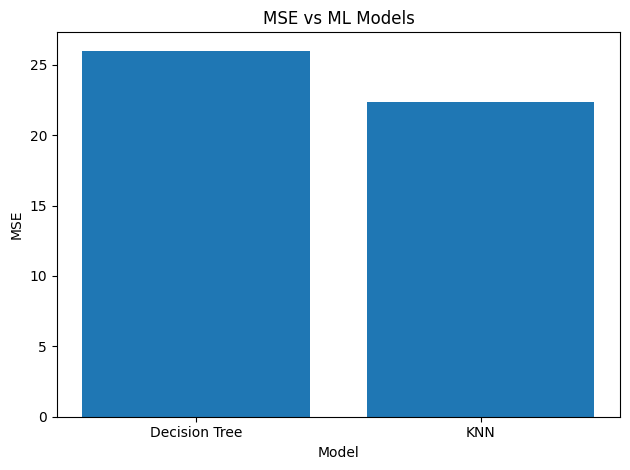

In [37]:
for colname in metrics:
    fig, ax = plt.subplots()

    ax.bar(selected_models, output_df[colname])

    if len(selected_models) > 1:
        ax.set_title(f"{colname} vs ML Models")
    else:
        ax.set_title(f"{colname} vs {selected_models[0]}")

    ax.set_ylabel(colname)
    ax.set_xlabel("Model")
    fig.tight_layout()
    plt.show()